With adversarial machine learning we try to exploit / abuse the model by deriving information about the model to create specific edge cases in our model. 

An example of this could be the detection of persons in a camera frame, if the subject holds an object this could make the network miss the subject. With advarsarial machine learning we try to find these edge cases.

We will be testing this with Generative adversarial network (GAN) and Auto encoder, we will use these to generate images, the autoencoder will attempt to classify the images before generate them after. 

### something about the generator...


In [4]:
from numpy import zeros, ones, expand_dims
from numpy.random import randint, randn


from keras.layers import Conv2D, LeakyReLU, Dense, Flatten, Conv2DTranspose, Reshape, Dropout
from keras.models import load_model, Sequential
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam

import matplotlib.pyplot as plt

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


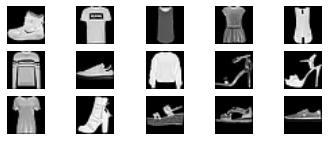

In [5]:
# Load the data
(X_train, y_train), (X_test, y_test) = load_data()

# Show shape
print('Train {} {}'.format(X_train.shape, y_train.shape))
print('Test {} {}'.format(X_test.shape, y_test.shape))

# Examples from train set.
for i in range(15):
	plt.subplot(5, 5, 1 + i); plt.axis('off')
	plt.imshow(X_train[i], cmap='gray', interpolation = 'bilinear') 
    

The training data for the discriminator originates from two places:

* Real-world data examples, such as real-world portraits of people. During training, the discriminator considers these examples as positive examples.
* The generator generates fake data instances. During training, the discriminator uses these situations as negative examples.

In a GAN, the discriminator is just a classifier. It tries to tell the difference between genuine data and data generated by the generator. Any network architecture relevant to the type of data it's classifying could be used.

## Model definition

Defining the discriminator

In [6]:
discriminator_model = Sequential()

discriminator_model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same', input_shape = (28,28,1)))
discriminator_model.add(LeakyReLU(alpha = 0.2))
discriminator_model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
discriminator_model.add(LeakyReLU(alpha = 0.2))

discriminator_model.add(Flatten())
discriminator_model.add(Dropout(0.4))
discriminator_model.add(Dense(1, activation = 'sigmoid'))

discriminator_model.trainable = False

# compile model
discriminator_model.compile(loss='squared_hinge', optimizer = 'adam', metrics = ['accuracy'])

2022-05-09 10:48:27.707786: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-09 10:48:27.708406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 10:48:27.714516: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Defining the generator


In [7]:
generator_model = Sequential()

latent_dimensions = 100

# Initialize on 7x7
generator_model.add(Dense(6272, input_dim = latent_dimensions))
generator_model.add(LeakyReLU(alpha=0.2))
generator_model.add(Reshape((7, 7, 128)))

# 14x14 Upsample
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(LeakyReLU(alpha=0.2))

# 28x28 Upsample 
generator_model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(LeakyReLU(alpha=0.2))

generator_model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
generator_model.compile(loss = 'squared_hinge', optimizer = 'adam')


Define GAN model.

In [8]:
gan_model = Sequential()
gan_model.add(generator_model)
gan_model.add(discriminator_model)

gan_model.compile(loss='squared_hinge', optimizer='adam')


### Prepare the data

In [9]:
def load_real_samples():
	(train_X, _), (_, _) = load_data()

	X = expand_dims(train_X, axis=-1)
	X = X.astype('float32')
    # To get values between -1 and 1, delete half of the list and divide by half.

	X = (X-127.5) /127.5 
	return X


# returns a list of images based on the number of samples required
def generate_real_samples(dataset, n_sample):
	# choose random instances
	i_x = randint(0, dataset.shape[0], n_sample)
	X = dataset[i_x]
	y = ones((n_sample, 1))
    
	return X, y

# generate points in number areas
def generate_latent_points(latent_dim, n_sample):
	x_input = randn(latent_dim * n_sample)
	x_input = x_input.reshape(n_sample, latent_dim)
    
	return x_input

# generate new points
def generate_fake_samples(generator, latent_dim, n_sample):
	x_input = generate_latent_points(latent_dim, n_sample)
	X = generator.predict(x_input)
	y = zeros((n_sample, 1))
    
	return X, y

Define the training function, to train the generator / discriminator

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 3, n_batch = 128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator_model.h5')

# Load data
dataset = load_real_samples()
# train model
train(generator_model, discriminator_model, gan_model, dataset, 100)

>1, 1/468, d1=0.269, d2=2.249 g=0.250
>1, 2/468, d1=0.266, d2=2.256 g=0.248
>1, 3/468, d1=0.265, d2=2.271 g=0.243
>1, 4/468, d1=0.267, d2=2.293 g=0.236
>1, 5/468, d1=0.265, d2=2.320 g=0.226
>1, 6/468, d1=0.267, d2=2.359 g=0.214
>1, 7/468, d1=0.266, d2=2.397 g=0.207
>1, 8/468, d1=0.265, d2=2.420 g=0.199
>1, 9/468, d1=0.267, d2=2.424 g=0.200
>1, 10/468, d1=0.264, d2=2.436 g=0.194
>1, 11/468, d1=0.266, d2=2.449 g=0.190
>1, 12/468, d1=0.266, d2=2.468 g=0.190
>1, 13/468, d1=0.269, d2=2.473 g=0.181
>1, 14/468, d1=0.263, d2=2.487 g=0.178
>1, 15/468, d1=0.267, d2=2.491 g=0.179
>1, 16/468, d1=0.268, d2=2.483 g=0.173
>1, 17/468, d1=0.264, d2=2.484 g=0.175
>1, 18/468, d1=0.268, d2=2.509 g=0.176
>1, 19/468, d1=0.264, d2=2.518 g=0.172
>1, 20/468, d1=0.269, d2=2.522 g=0.169
>1, 21/468, d1=0.271, d2=2.511 g=0.169
>1, 22/468, d1=0.269, d2=2.549 g=0.167
>1, 23/468, d1=0.269, d2=2.531 g=0.162
>1, 24/468, d1=0.265, d2=2.526 g=0.165
>1, 25/468, d1=0.262, d2=2.549 g=0.164
>1, 26/468, d1=0.271, d2=2.556 g=0

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
model_generator = load_model('../models/generator_model.h5')
latent_points = generate_latent_points(100, 100)
X = model_generator.predict(latent_points)
show_plot(X, 10)

## Evaluation

Because this is a standard GAN model we cant choose the type of input to be ignored. A random point is chose in latent space for the latent dimensions. this dimension is then used to generate the image. This means we cant choose the type of clothing. This can be solved by creating a conditional GAN. 

From the results we can see that there is some progression in the training, the latent space is the area of possible integers.